# **Foundations of Data Science Fall 2022 - Homework 3 (30 points)**

### Student Name: Pranjal Jain
### Student Net Id: pj2069


---

In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.stattools import durbin_watson
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import plot_roc_curve
%matplotlib inline

In this assignment we will be looking at data generated by particle physicists to test whether machine learning can help classify whether certain particle decay experiments identify the presence of a Higgs Boson. One does not need to know anything about particle physics to do well here, but if you are curious, full feature and data descriptions can be found here:

- https://www.kaggle.com/c/higgs-boson/data
- http://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf

The goal of this assignment is to learn to use cross-validation for model selection as well as bootstrapping for error estimation. We’ll also use learning curve analysis to understand how well different algorithms make use of limited data. For more documentation on cross-validation with Python, you can consult the following:

- http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation


### Part 1: Data preparation (6 Points)
---



Create a data preparation and cleaning function that does the following:
- Has a single input that is a file name string
- Reads data (the data is comma separated, has a row header and the first column `EventID` is the index) into a pandas `dataframe`
- Cleans the data
  - Convert the feature `Label` to numeric (choose the minority class to be equal to 1)
    - Create a feature `Y` with numeric label
    - Drop the feature `Label`
  - If a feature has missing values (i.e., `-999`): 
    - Create a dummy variable for the missing value
      - Call the variable `orig_var_name` + `_mv` where `orig_var_name` is the name of the actual var with a missing value
      - Give this new variable a 1 if the original variable is missing
    - Replace the missing value with the average of the feature (make sure to compute the mean on records where the value isn't missing). You may find pandas' `.replace()` function useful.
- After the above is done, rescales the data so that each feature has zero mean and unit variance (hint: look up sklearn.preprocessing)
- Returns the cleaned and rescaled dataset

Hint: as a guide, this function can easily be done in less than 15 lines.

In [179]:
# Place your code here
def cleandata(file):
  df = pd.read_csv(file, index_col= 'EventId', na_values=-999)


  value = df['Label'].value_counts().sort_values(ascending = True)
  df_val = pd.DataFrame(value)
  df_val = df_val.reset_index()
  df_val.columns = ['label', 'count']
  minor = df_val['label'].iloc[0] 

  df.loc[df['Label'] == minor, 'Y'] = 1
  df.loc[df['Label'] != minor, 'Y'] = 0
  df.drop(columns='Label', inplace = True)


  mean = df.mean(axis = 'index')
  df_mean = pd.DataFrame(mean)
  df_mean = df_mean.reset_index()
  df_mean.columns = ['feature', 'mean']

  for features in df.columns[:-1]:
    df[features+'_mv'] = df[features]
    df.loc[df[features].isnull(), features+'_mv'] = 1

    v = df_mean.loc[df_mean['feature'] == features, 'mean'].values[0]
    df[features+'_mv'].replace(to_replace= 1, value = v, inplace= True)

    scaler = StandardScaler()
    df[[features+'_mv']]=scaler.fit_transform(df[[features+'_mv']])
  return df

### Part 2: Basic evaluations (6 Points)
---

In this part you will build an out-of-the box logistic regression (LR) model and support vector machine (SVM). You will then plot ROC for the LR and SVM model.

1\. Clean the two data files included in this assignment (`data/boson_training_cut_2000.csv` and `data/boson_testing_cut.csv`) and use them as training and testing data sets.

(1 Point)

In [180]:
# Place your code here

train = cleandata('boson_training_cut_2000.csv')
test = cleandata('boson_testing_cut.csv')
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 300000 to 349999
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   DER_mass_MMC                    42412 non-null  float64
 1   DER_mass_transverse_met_lep     50000 non-null  float64
 2   DER_mass_vis                    50000 non-null  float64
 3   DER_pt_h                        50000 non-null  float64
 4   DER_deltaeta_jet_jet            14592 non-null  float64
 5   DER_mass_jet_jet                14592 non-null  float64
 6   DER_prodeta_jet_jet             14592 non-null  float64
 7   DER_deltar_tau_lep              50000 non-null  float64
 8   DER_pt_tot                      50000 non-null  float64
 9   Y                               50000 non-null  float64
 10  DER_mass_MMC_mv                 50000 non-null  float64
 11  DER_mass_transverse_met_lep_mv  50000 non-null  float64
 12  DER_mass_vis_mv           

2\. On the training set, build the following models:

- A logistic regression using sklearn's `linear_model.LogisticRegression()`. For this model, use `C=1e30`.
- An SVM using sklearn's `svm.svc()`. For this model, specify that `kernel="linear"`.

For each model above, plot the ROC curve of both models on the same plot. Make sure to use the test set for computing and plotting. In the legend, also print out the Area Under the ROC (AUC) for reference. 

(Hint: to get the prediction thresholds that are necessary for the AUC, use function predict_proba() for KNN and for the classifier you choose if it has it. If you work with SVM, use function decision_function().)

(4 Points)

In [181]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
%matplotlib inline
from sklearn.metrics import roc_curve, auc

from sklearn.svm import SVC
from sklearn import svm


X_features = ['DER_mass_MMC_mv','DER_mass_transverse_met_lep_mv','DER_mass_vis_mv','DER_pt_h_mv','DER_deltaeta_jet_jet_mv','DER_mass_jet_jet_mv','DER_prodeta_jet_jet_mv','DER_deltar_tau_lep_mv','DER_pt_tot_mv']
Y_target = ['Y']

model_Log = LogisticRegression(C=1e30)
model_Log.fit(train[X_features], train[Y_target])
y_pred_test = model_Log.predict(test[X_features])

print("Logitic Accuracy:",metrics.accuracy_score(test[Y_target], y_pred_test))
probab_logistic = model_Log.predict_proba(test[X_features])[::,1]
test_fpr, test_tpr, te_thresholds = roc_curve(test[Y_target], probab_logistic)


clf = svm.SVC(kernel='linear')
clf.fit(train[X_features], train[Y_target])
y_pred_test_SVM = clf.predict(test[X_features])
print("SVM Accuracy:",metrics.accuracy_score(test[Y_target], y_pred_test_SVM))

probab_SVM = clf.decision_function(test[X_features])
test_SVM_fpr, test_SVM_tpr, te_SVM_thresholds = roc_curve(test[Y_target], probab_SVM)



Logitic Accuracy: 0.72092


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM Accuracy: 0.69934


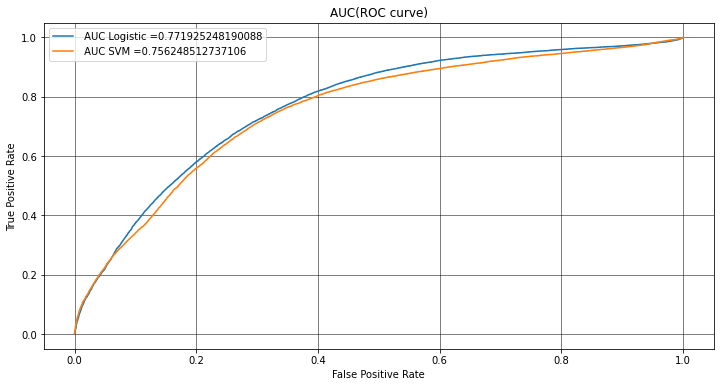

In [182]:
#Now we plot the AUCs
# Place your code here

fig = plt.figure(figsize = (12, 6))
plt.plot(test_fpr, test_tpr, label=" AUC Logistic ="+str(auc(test_fpr, test_tpr)))
plt.plot(test_SVM_fpr, test_SVM_tpr, label=" AUC SVM ="+str(auc(test_SVM_fpr, test_SVM_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)

3\. Which of the two models is generally better at ranking the test set? Are there any classification thresholds where the model identified above as "better" would underperform the other in a classification metric (such as TPR)?

(1 Point)

*Write your answer here*

From the graph we can see that logistic regression overal performs better than SVM as we can see in AUC values for both. There are some thresholds where SVM performs better such as for values below 0.2 for TPR and for above 0.9 TPR.

### Part 3: Model selection with cross-validation (8 Points)

We think we might be able to improve the performance of the SVM if we perform a grid search on the hyper-parameter $C$.  Because we only have 1000 instances, we will have to use cross-validation to find the optimal $C$.

1\. Write a cross-validation function that does the following:
- Takes as inputs a dataset, a label name, # of splits/folds (`k`), a sequence of values for $C$ (`cs`)
- Performs two loops
  - Outer Loop: `for each f in range(k)`:
    - Splits the data into `data_train` & `data_validate` according to cross-validation logic
  - Inner Loop: `for each c in cs`:
    - Trains an SVM on training split with `C=c, kernel="linear"`
    - Computes AUC_c_k on validation data
    - Stores AUC_c_k in a  dictionary of values
- Returns a dictionary, where each key-value pair is: `c:[auc-c1,auc-c2,..auc-ck]`
---

In [183]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Place your code here


def xValSVM(dataset,X_features, label_name, k, cArray):
    
  result = {}
  for i in cArray:
    result[i]=[]  
  kfold = KFold(n_splits=k, shuffle=True)
  for train, test in kfold.split(dataset):
    k_train = dataset.iloc[train,:]
    k_test = dataset.iloc[test,:]
    for value in cArray:
      clf = svm.SVC(kernel='linear', C = value)
      clf.fit(k_train[X_features], k_train[label_name].values.ravel())
      y_pred = clf.predict(k_test[X_features])
      probab_SVM = clf.decision_function(k_test[X_features])
      test_SVM_fpr, test_SVM_tpr, te_SVM_thresholds = roc_curve(k_test[Y_target], probab_SVM)
      result[value].append(auc(test_SVM_fpr, test_SVM_tpr))
  #print(result)
  return result

2\. Using the function written above, do the following:
- Generate a sequence of 10 $C$ values in the interval `[10^(-8), ..., 10^1]` (i.e., do all powers of 10 from -8 to 1).
2.	Call aucs = xValSVM(train, ‘Y’, 10, cs)
3.	For each c in cs, get mean(AUC) and StdErr(AUC) 
4.	Compute the value for max(meanAUC-StdErr(AUC)) across all values of c.
5.	Generate a plot with the following:
a.	Log10(c) on the x-axis
b.	1 series with mean(AUC) for each c
c.	1 series with mean(AUC)-stderr(AUC) for each c (use ‘k+’ as color pattern)
d.	1 series with mean(AUC)+stderr(AUC) for each c (use ‘k--‘ as color pattern)
e.	a reference line for max(AUC-StdErr(AUC)) (use ‘r’ as color pattern)


In [184]:
# Place your code here
import numpy as np
import statistics

kfoldSplit = 10
cArray = np.logspace(-8, 1, 10)

print(cArray)
valDict = xValSVM(train,X_features,Y_target , kfoldSplit, cArray)


[1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01]


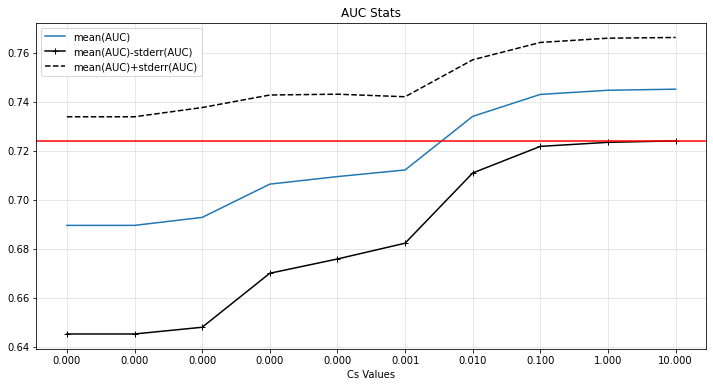

In [185]:
import numpy as np

mean = []
std = []
max = []
meanMinStd = []
meanPlStd = []
csArray = [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0 , 10]
for i in valDict.keys():
  mean.append(statistics.mean(valDict[i]))
  std.append(statistics.stdev(valDict[i]))
  meanMinStd.append(statistics.mean(valDict[i]) - statistics.stdev(valDict[i]))
  meanPlStd.append(statistics.mean(valDict[i]) + statistics.stdev(valDict[i]))

maximum = -1
for j in meanMinStd:
  if j >= maximum:
    maximum = j

plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.set_xscale('log')
ax.set_xticks(csArray)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())


plt.plot(csArray, mean, label = "mean(AUC)")
plt.plot(csArray, meanMinStd,"k+-" , label = "mean(AUC)-stderr(AUC)")
plt.plot(csArray, meanPlStd,"k--" , label = "mean(AUC)+stderr(AUC)")
plt.xlabel("Cs Values")
plt.title("AUC Stats")
plt.axhline(y = maximum, color = 'r', linestyle = '-')
plt.legend()
plt.grid(color='lightgray', linestyle='-', linewidth=0.5)
plt.show()

Did the model parameters selected beat the out-of-the-box model for SVM? (1 point)

*Write your answer here*

No the selected parameters are not better than the out of the box values since it never goes above 0.75

###Part 4: Learning Curve with Bootstrapping (10 Points)
---




In this HW we are trying to find the best linear model to predict if a record represents the Higgs Boson. One of the drivers of the performance of a model is the sample size of the training set.  As a data scientist, sometimes you have to decide if you have enough data or if you should invest in more.  We can use learning curve analysis to determine if we have reached a performance plateau. This will inform us on whether or not we should invest in more data (in this case it would be by running more experiments).

Given a training set of size $N$, we test the performance of a model trained on a subsample of size $N_i$, where $N_i<=N$.  We can plot how performance grows as we move $N_i$ from $0$ to $N$.  

Because of the inherent randomness of subsamples of size $N_i$, we should expect that any single sample of size $N_i$ might not be representative of an algorithm’s performance at a given training set size. To quantify this variance and get a better generalization, we will also use bootstrap analysis. In bootstrap analysis, we pull multiple samples of size $N_i$, build a model, evaluate on a test set, and then take an average and standard error of the results.

1\. Create a bootstrap function that can do the following:

def modBootstrapper(train, test, nruns, sampsize, lr, c):

-	Takes as input:
    -	A master training file (train)
    -	A master testing file (test)
    -	Number of bootstrap iterations (nruns) 
    -	Size of a bootstrap sample (sampsize)
    -	An indicator variable to specific LR or SVM (lr=1)
    -	A c option (only applicable to SVM)

-	Runs a loop with (nruns) iterations, and within each loop:
    -	Sample (sampsize) instances from train, with replacement
    -	Fit either an SVM or LR (depending on options specified). For SVM, use the value of C identified using the 1 standard error method from part 3.    
    -	Computes AUC on test data using predictions from model in above step
    -	Stores the AUC in a list

-	Returns the mean(AUC) and Standard Error(mean(AUC)) across all bootstrap samples


In [186]:

# Place your code here
from sklearn.metrics import roc_auc_score
def modBootstrapper(train, test, nruns, sampsize, lr, c):
    
    result = []

    for i in range(0,nruns):

        sample_train = train.iloc[np.random.randint(0, len(train), size=sampsize)]  

        if lr == 1:
            lrMod = LogisticRegression(C=c)
            lrMod.fit(sample_train[X_features], sample_train[Y_target].values.ravel())
            preds = lrMod.predict_proba(test[X_features])[:,1]
        elif lr == 0:
            clf = svm.SVC(kernel='linear')
            clf.fit(sample_train[X_features], sample_train[Y_target].values.ravel())
            preds = clf.predict(test[X_features])
        else: 
          print("Incorrect Value for LR")

        result.append(roc_auc_score(test[Y_target], preds))
    
    mean_result = np.mean(result)
    std_result = np.sqrt(np.var(result))
    
    return [mean_result, std_result]

2\. For both LR and SVM, run 20 bootstrap samples for each samplesize in the following list: samplesizes = [50, 100, 200, 500, 1000, 1500, 2000]. (Note, this might take 10-15 mins … feel free to go grab a drink or watch Youtube while this runs).

Generate a plot with the following:
-	Log2(samplesize) on the x-axis
-	2 sets of results lines, one for LR and one for SVM, the set should include
    -	1 series with mean(AUC) for each sampsize (use the color options ‘g’ for svm, ‘r’ for lr)
    -	1 series with mean(AUC)-stderr(AUC) for each c (use ‘+’ as color pattern, ‘g’,’r’ for SVM, LR respectively)
    -	1 series with mean(AUC)+stderr(AUC) for each c (use ‘--‘ as color pattern ‘g’,’r’ for SVM, LR respectively)

(6 Points. Same as above, this section does not work without above section, so the points are coupled)

In [187]:
# Place your code here

samplesizes = [50, 100, 200, 500, 1000, 1500, 2000]

logMean={}
logStd={}
svmMean={}
svmStd={}

for i in samplesizes:
    mean_LR, std_LR = modBootstrapper(train, test, 20, i, 1, 1.0) # default c =1 for LR
    logMean[i] = mean_LR
    logStd[i] = std_LR
        
    mean_SVM, std_SVM = modBootstrapper(train=train, test=test, nruns=20, sampsize=i, lr=0, c=0.1)      
    svmMean[i] = mean_SVM
    svmStd[i] = std_SVM
dicts = [logMean, logStd, svmMean, svmStd]

finalDF = pd.DataFrame(dicts).T
finalDF.columns = ["logistic-Mean", "logistic_Std", "SVM_Mean", "SVM_Std"]
finalDF

,logistic-Mean,logistic_Std,SVM_Mean,SVM_Std
50,0.694267,0.041467,0.613238,0.054245
100,0.742993,0.015310,0.604391,0.051245
200,0.744558,0.021083,0.595337,0.057143
500,0.761198,0.007567,0.581921,0.043265
1000,0.767036,0.003955,0.586690,0.034756
1500,0.768158,0.002579,0.585664,0.026987
2000,0.770048,0.001420,0.586869,0.021972


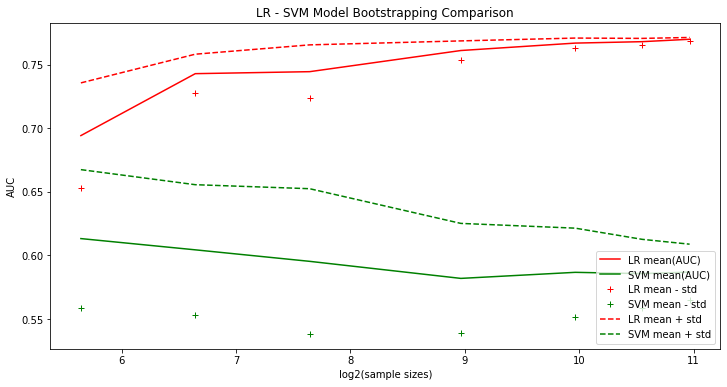

In [188]:
  #Plot lr bootstrap
plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

plt.plot(np.log2(samplesizes), finalDF["logistic-Mean"],'r', label="LR mean(AUC)")
plt.plot(np.log2(samplesizes), finalDF["SVM_Mean"],'g', label="SVM mean(AUC)")

plt.plot(np.log2(samplesizes), finalDF["logistic-Mean"]-finalDF["logistic_Std"], "r+", label="LR mean - std")
plt.plot(np.log2(samplesizes), finalDF["SVM_Mean"]-finalDF["SVM_Std"], "g+", label="SVM mean - std")

plt.plot(np.log2(samplesizes), finalDF["logistic-Mean"]+finalDF["logistic_Std"], "r--", label="LR mean + std")
plt.plot(np.log2(samplesizes), finalDF["SVM_Mean"]+finalDF["SVM_Std"], "g--", label="SVM mean + std")


plt.xlabel('log2(sample sizes)')
plt.ylabel('AUC')
plt.title('LR - SVM Model Bootstrapping Comparison')
plt.legend(loc="lower right")
plt.show()

3\. Which of the two algorithms are more suitable for smaller sample sizes, given the set of features? If it costs twice the investment to run enough experiments to double the data, do you think it is a worthy investment?

(2 Points)

*Write your answer here*

From the graph, LR always performs better in all sample sizes. It also plateaus so it does not seem fasilble to double the training data. 

4\. Is there a reason why cross-validation might be biased? If so, in what direction is it biased? (Hint: refer to the book - The Elements of Statistical Learning figure 7.8)?

(2 Points)

*Write your answer here*

if the learning curve has a considerable slope at the given
training set size for a graph for size of training set and 1-Err, tenfold cross-validation will overestimate the true
prediction error. Since our dataset has limited values, a training on 90% of the dataset also causes it to over-estimate the TPR.